In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import traceback
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


class HRAnalyticsModel:
    def __init__(self):
        self.employees_df = self.create_sample_employees()
        self.departments_df = self.create_sample_departments()
        self.performance_df = self.create_sample_performance()
        self.attendance_df = self.create_sample_attendance()
        self.training_df = self.create_sample_training()
    
    @staticmethod
    def create_sample_employees(n=100):
        departments = ['IT', 'HR', 'Finance', 'Marketing', 'Operations', 'Sales']
        job_titles = {
            'IT': ['Software Engineer', 'Data Analyst', 'System Admin', 'IT Manager'],
            'HR': ['HR Specialist', 'Recruiter', 'HR Manager', 'Training Coordinator'],
            'Finance': ['Accountant', 'Financial Analyst', 'Finance Manager', 'Auditor'],
            'Marketing': ['Marketing Specialist', 'Content Creator', 'Marketing Manager', 'SEO Analyst'],
            'Operations': ['Operations Manager', 'Logistics Coordinator', 'Supply Chain Specialist'],
            'Sales': ['Sales Representative', 'Account Manager', 'Sales Manager', 'Business Development']
        }
        
        data = []
        start_date = datetime(2018, 1, 1)
        
        for i in range(n):
            dept = random.choice(departments)
            job = random.choice(job_titles[dept])
            hire_date = start_date + timedelta(days=random.randint(0, 1000))
            
            employee = {
                'employee_id': i + 1,
                'first_name': f'Employee{random.randint(1, 1000)}',
                'last_name': f'Last{random.randint(1, 1000)}',
                'email': f'employee{i+1}@company.com',
                'department': dept,
                'job_title': job,
                'hire_date': hire_date,
                'salary': random.randint(30000000, 120000000),
                'manager_id': random.randint(1, 10) if i > 9 else None,
                'status': random.choices(['active', 'resigned', 'terminated'], 
                                         weights=[0.8, 0.15, 0.05])[0]
            }
            data.append(employee)
        
        return pd.DataFrame(data)
    

    @staticmethod
    def create_sample_departments():
        data = [{'department_id': 1, 'department_name': 'IT', 'location': 'Jakarta', 'budget': 5000000000},
                {'department_id': 2, 'department_name': 'HR', 'location': 'Jakarta', 'budget': 2000000000},
                {'department_id': 3, 'department_name': 'Finance', 'location': 'Jakarta', 'budget': 3000000000},
                {'department_id': 4, 'department_name': 'Marketing', 'location': 'Jakarta', 'budget': 4000000000},
                {'department_id': 5, 'department_name': 'Operations', 'location': 'Bandung', 'budget': 3500000000},
                {'department_id': 6, 'department_name': 'Sales', 'location': 'Jakarta', 'budget': 4500000000}]
        
        return pd.DataFrame(data)
    
    
    def create_sample_performance(self):
        data = []
        current_date = datetime.now()
        
        for emp_id in self.employees_df['employee_id']:
            for year in [2022, 2023, 2024]:
                review_date = datetime(year, random.randint(1, 12), random.randint(1, 28))
                
                if review_date < current_date:
                    review = {
                        'employee_id': emp_id,
                        'review_date': review_date,
                        'rating': round(random.uniform(3.0, 5.0), 1),
                        'reviewer_id': random.randint(1, 10),
                        'comments': f'Performance review for {year}'
                    }
                    data.append(review)
        
        return pd.DataFrame(data)
    
    
    def create_sample_attendance(self, days=90):
        data = []
        start_date = datetime.now() - timedelta(days=days)
        
        for emp_id in self.employees_df[self.employees_df['status'] == 'active']['employee_id']:
            for day in range(days):
                date = start_date + timedelta(days=day)
                
                if date.weekday() < 5:  # Only weekdays
                    status = random.choices(['present', 'absent', 'late', 'early_departure'],
                                            weights=[0.85, 0.05, 0.07, 0.03])[0]
                    
                    if status == 'present':
                        hours = random.uniform(7.5, 9.5)
                    elif status == 'late':
                        hours = random.uniform(6.0, 8.0)
                    elif status == 'early_departure':
                        hours = random.uniform(5.0, 7.0)
                    else:
                        hours = 0
                    
                    attendance = {
                        'employee_id': emp_id,
                        'date': date,
                        'status': status,
                        'hours_worked': round(hours, 2)
                    }
                    data.append(attendance)
        
        return pd.DataFrame(data)
    
    
    def create_sample_training(self):
        trainings = [{'training_id': 1, 'name': 'Leadership Workshop', 'category': 'Soft Skills'},
                     {'training_id': 2, 'name': 'Coding', 'category': 'Technical'},
                     {'training_id': 3, 'name': 'Data Analysis', 'category': 'Technical'},
                     {'training_id': 4, 'name': 'Communication Skills', 'category': 'Soft Skills'},
                     {'training_id': 5, 'name': 'Project Management', 'category': 'Management'}]
        
        data = []
        for training in trainings:
            participants = random.sample(list(self.employees_df['employee_id']), 
                                         random.randint(15, 30))
            
            for emp_id in participants:
                participant = {
                    'employee_id': emp_id,
                    'training_id': training['training_id'],
                    'training_name': training['name'],
                    'category': training['category'],
                    'score': round(random.uniform(60, 100), 2),
                    'completion_date': datetime(2024, random.randint(1, 12), random.randint(1, 28))
                }
                data.append(participant)
        
        return pd.DataFrame(data)
    
    
    """Analytics"""
    def calculate_turnover_rate(self):
        total_employees = len(self.employees_df)
        departed = len(self.employees_df[self.employees_df['status'] != 'active'])
        turnover_rate = (departed / total_employees) * 100 if total_employees > 0 else 0
        
        return round(turnover_rate, 2)
    
    
    def analyze_department_performance(self):
        merged_df = pd.merge(self.performance_df, self.employees_df, on='employee_id')
        dept_performance = merged_df.groupby('department')['rating'].agg(['mean', 'count', 'std', 
                                                                          'min', 'max']).round(2)
        
        return dept_performance
    
    
    def attendance_analysis(self):
        analysis = {
            'total_days_recorded': len(self.attendance_df),
            'present_days': len(self.attendance_df[self.attendance_df['status'] == 'present']),
            'absent_days': len(self.attendance_df[self.attendance_df['status'] == 'absent']),
            'late_days': len(self.attendance_df[self.attendance_df['status'] == 'late']),
            'average_hours_worked': round(self.attendance_df['hours_worked'].mean(), 2),
            'attendance_rate': round((len(self.attendance_df[self.attendance_df['status'] == 'present']) /
                                      len(self.attendance_df)) * 100, 2)
        }
        
        return analysis
    
    
    def salary_analysis(self):
        salary_stats = self.employees_df.groupby('department')['salary'].agg(['mean', 'median', 'std', 'min',
                                                                              'max', 'count']).round(2)
        
        # Convert to millions for readability
        for col in ['mean', 'median', 'std', 'min', 'max']:
            salary_stats[col] = (salary_stats[col] / 1000000).round(2)
        
        salary_stats.rename(columns={
            'mean': 'avg_salary_million',
            'median': 'median_salary_million',
            'std': 'std_salary_million',
            'min': 'min_salary_million', 
            'max': 'max_salary_million'
        }, inplace=True)
        
        return salary_stats
    
    
    def retention_analysis(self):
        current_date = datetime.now()
        self.employees_df['tenure_years'] = ((current_date - pd.to_datetime(self.employees_df['hire_date'])).dt.days /
                                             365.25).round(2)
        retention_stats = self.employees_df.groupby('department')['tenure_years'].agg(['mean', 'median', 'std',
                                                                                       'count']).round(2)
        
        return retention_stats
    
    
    def training_effectiveness(self):
        latest_performance = self.performance_df.sort_values('review_date').groupby('employee_id').last().reset_index()
        merged_data = pd.merge(self.training_df, latest_performance, on='employee_id')
        
        effectiveness = merged_data.groupby('training_name').agg({
            'score': 'mean',
            'rating': 'mean',
            'employee_id': 'count'
        }).round(2).rename(columns={'employee_id': 'participants_count'})
        
        return effectiveness
    
    
    def generate_comprehensive_report(self):
        comprehensive_report = {
            'turnover_rate': self.calculate_turnover_rate(),
            'department_performance': self.analyze_department_performance(),
            'attendance_stats': self.attendance_analysis(),
            'salary_analysis': self.salary_analysis(),
            'retention_analysis': self.retention_analysis(),
            'training_effectiveness': self.training_effectiveness(),
            'employee_summary': {
                'total_employees': len(self.employees_df),
                'active_employees': len(self.employees_df[self.employees_df['status'] == 'active']),
                'departments_count': self.employees_df['department'].nunique(),
                'average_salary': f"Rp {self.employees_df['salary'].mean():,.0f}",
                'average_tenure': f"{self.employees_df['tenure_years'].mean():.1f} years"
            }
        }
        
        return comprehensive_report
    
    
    """Visualization"""
    def plot_turnover_by_department(self):
        turnover_by_dept = self.employees_df.groupby('department')['status'].apply(lambda x: (x != 'active').mean() * 100).round(2)
        
        plt.figure(figsize=(10, 6))
        turnover_by_dept.sort_values().plot(kind='bar', color='skyblue')
        plt.title('Turnover Rate by Department')
        plt.xlabel('Department')
        plt.ylabel('Turnover Rate (%)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_salary_distribution(self):
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        self.employees_df['salary_million'] = self.employees_df['salary'] / 1000000
        sns.histplot(self.employees_df['salary_million'], bins=20, kde=True)
        plt.title('Salary Distribution (in millions)')
        plt.xlabel('Salary (Million IDR)')
        
        plt.subplot(1, 2, 2)
        salary_by_dept = self.employees_df.groupby('department')['salary_million'].mean().sort_values()
        salary_by_dept.plot(kind='bar', color='lightgreen')
        plt.title('Average Salary by Department')
        plt.xlabel('Department')
        plt.ylabel('Average Salary (Million IDR)')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def plot_performance_trends(self):
        merged_df = pd.merge(self.performance_df, self.employees_df, on='employee_id')
        performance_trend = merged_df.groupby([pd.to_datetime(merged_df['review_date']).dt.year, 
                                               'department'])['rating'].mean().unstack()
        
        plt.figure(figsize=(12, 6))
        performance_trend.plot(marker='o')
        plt.title('Performance Rating Trend by Department')
        plt.xlabel('Year')
        plt.ylabel('Average Rating')
        plt.legend(title='Department')
        plt.grid(True)
        plt.show()
    
    def plot_attendance_patterns(self):
        plt.figure(figsize=(15, 10))
        
        # Attendance by day of week
        self.attendance_df['day_of_week'] = pd.to_datetime(self.attendance_df['date']).dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        
        plt.subplot(2, 2, 1)
        attendance_by_day = self.attendance_df['day_of_week'].value_counts().reindex(day_order)
        attendance_by_day.plot(kind='bar', color='lightblue')
        plt.title('Attendance by Day of Week')
        plt.xlabel('Day')
        plt.ylabel('Count')
        
        # Attendance status distribution
        plt.subplot(2, 2, 2)
        status_counts = self.attendance_df['status'].value_counts()
        plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%')
        plt.title('Attendance Status Distribution')
        
        # Average hours by department
        plt.subplot(2, 2, 3)
        merged_attendance = pd.merge(self.attendance_df, self.employees_df, on='employee_id')
        hours_by_dept = merged_attendance.groupby('department')['hours_worked'].mean().sort_values()
        hours_by_dept.plot(kind='bar', color='orange')
        plt.title('Average Hours Worked by Department')
        plt.xlabel('Department')
        plt.ylabel('Average Hours')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        

"""Sample ML turnover prediction"""
class HRPredictiveModel(HRAnalyticsModel):
    def __init__(self):
        super().__init__()
        self.ml_models = {}
    
    def prepare_features_for_ml(self):
        features_df = self.employees_df.copy()
        
        # Feature engineering - make sure handle missing values
        features_df['tenure'] = (datetime.now() - pd.to_datetime(features_df['hire_date'])).dt.days / 365.25
        features_df['tenure'] = features_df['tenure'].fillna(0)
        
        features_df['salary_normalized'] = features_df['salary'] / features_df['salary'].max()
        features_df['salary_normalized'] = features_df['salary_normalized'].fillna(0)
        
        # Aggregate performance data
        perf_agg = self.performance_df.groupby('employee_id')['rating'].agg(['mean', 'std', 'count']).reset_index()
        perf_agg.columns = ['employee_id', 'performance_mean', 'performance_std', 'performance_count']
        
        features_df = features_df.merge(perf_agg, on='employee_id', how='left')
        
        # Fill missing performance values
        features_df['performance_mean'] = features_df['performance_mean'].fillna(features_df['performance_mean'].median())
        features_df['performance_std'] = features_df['performance_std'].fillna(0)
        features_df['performance_count'] = features_df['performance_count'].fillna(0)
        
        # Aggregate attendance data
        if not self.attendance_df.empty:
            attendance_agg = self.attendance_df.groupby('employee_id').agg({
                'hours_worked': 'mean',
                'status': lambda x: (x == 'absent').mean()  # absence rate
            }).reset_index()
            attendance_agg.columns = ['employee_id', 'avg_hours_worked', 'absence_rate']
            features_df = features_df.merge(attendance_agg, on='employee_id', how='left')
            
            # Fill missing attendance values
            features_df['avg_hours_worked'] = features_df['avg_hours_worked'].fillna(features_df['avg_hours_worked'].median())
            features_df['absence_rate'] = features_df['absence_rate'].fillna(0)
            
        else:
            features_df['avg_hours_worked'] = 8.0  # default value
            features_df['absence_rate'] = 0.0
        
        # Convert categorical variables - make sure existing columns
        if 'department' in features_df.columns:
            features_df = pd.get_dummies(features_df, columns=['department'], prefix='dept')
        
        if 'job_title' in features_df.columns:
            features_df = pd.get_dummies(features_df, columns=['job_title'], prefix='job')
        
        return features_df
    
    def create_turnover_prediction_dataset(self):
        features_df = self.prepare_features_for_ml()
    
        if 'status' not in features_df.columns:
            print("Error: 'status' column not found in features_df")
            return None, None
        
        y = (features_df['status'] != 'active').astype(int)
        print(f"Label value counts: {y.value_counts().to_dict()}")
        columns_to_drop = ['employee_id', 'first_name', 'last_name', 'email', 'hire_date', 'status']
        columns_to_drop = [col for col in columns_to_drop if col in features_df.columns]
        x = features_df.drop(columns_to_drop, axis=1, errors='ignore')
        
        if 'will_resign' in x.columns:
            x = x.drop('will_resign', axis=1)
        
        print(f"X columns: {x.columns.tolist()}")
        print(f"X shape: {x.shape}, y shape: {y.shape}")
        
        return x, y
    
    def train_turnover_prediction_model(self):
        try:
            x, y = self.create_turnover_prediction_dataset()
            
            if x is None or y is None:
                print("Failed to create dataset")
                
                return None
        
            feature_names = x.columns.tolist()
            print(f"Feature names for model: {feature_names}")
            
            imputer = SimpleImputer(strategy='median')
            x_imputed = imputer.fit_transform(x)
            x_train, x_test, y_train, y_test = train_test_split(x_imputed,
                                                                y, 
                                                                test_size=0.2, 
                                                                random_state=42,
                                                                stratify=y)
            
            model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
            model.fit(x_train, y_train)
            
            y_pred = model.predict(x_test)
            print("Model Evaluation:")
            print(classification_report(y_test, y_pred))
            
            model.feature_names_ = feature_names
            
            self.ml_models['turnover_prediction'] = model
            self.ml_models['imputer'] = imputer
            self.ml_models['feature_names'] = feature_names
            
            print(f"Model trained successfully with {len(feature_names)} features")
            
            return model
                
        except Exception as e:
            print(f"Error training model: {e}")
            traceback.print_exc()
            
            return None
    
    def predict_turnover_risk(self, employee_id=None):
        try:
            if 'turnover_prediction' not in self.ml_models:
                print("Training model first...")
                self.train_turnover_prediction_model()
                
                if 'turnover_prediction' not in self.ml_models:
                    return None
            
            features_df = self.prepare_features_for_ml()
            
            # Ensure to drop several duplicate columns when training
            columns_to_drop = ['employee_id', 'first_name', 'last_name', 'email', 'hire_date', 'status']
            columns_to_drop = [col for col in columns_to_drop if col in features_df.columns]
            
            x_all = features_df.drop(columns_to_drop, axis=1, errors='ignore')
            
            if 'will_resign' in x_all.columns:
                x_all = x_all.drop('will_resign', axis=1)
                
            feature_names = self.ml_models['feature_names']
            print(f"Expected features: {feature_names}")
            print(f"Available features: {x_all.columns.tolist()}")
            
            missing_features = set(feature_names) - set(x_all.columns)
            extra_features = set(x_all.columns) - set(feature_names)
        
            if missing_features:
                print(f"Warning: Missing features {missing_features}, filling with 0")
                
                for feature in missing_features:
                    x_all[feature] = 0
            
            if extra_features:
                print(f"Warning: Dropping extra features {extra_features}")
                x_all = x_all.drop(list(extra_features), axis=1)
            
            x_all = x_all[feature_names]
            
            # Impute missing values
            x_all_imputed = self.ml_models['imputer'].transform(x_all)
            
            predictions = self.ml_models['turnover_prediction'].predict_proba(x_all_imputed)[:, 1]
            results = features_df[['employee_id', 'first_name', 'last_name']].copy()
            
            # Add department if needed
            if 'department' in features_df.columns:
                results['department'] = features_df['department']
                
            elif 'dept_IT' in features_df.columns:
                dept_columns = [col for col in features_df.columns if col.startswith('dept_')]
                
                if dept_columns:
                    results['department'] = features_df[dept_columns].idxmax(axis=1).str.replace('dept_', '')
            
            results['turnover_risk'] = (predictions * 100).round(2)
            results['status'] = features_df['status']
            
            return results.sort_values('turnover_risk', ascending=False)
                
        except Exception as e:
            print(f"Error predicting turnover risk: {e}")
            traceback.print_exc()
            
            return None
    
    def analyze_feature_importance(self):
        try:
            if 'turnover_prediction' not in self.ml_models:
                self.train_turnover_prediction_model()
            
            model = self.ml_models['turnover_prediction']
            x, _ = self.create_turnover_prediction_dataset()
            
            feature_importances = pd.DataFrame({
                'feature': model.feature_names_,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 8))
            sns.barplot(data=feature_importances.head(10), x='importance', y='feature')
            plt.title('Top 10 Features Affecting Employee Turnover')
            plt.tight_layout()
            plt.show()
            
            return feature_importances
            
        except Exception as e:
            print(f"Error analyzing feature importance: {e}")
            
            return None

In [25]:
# Testing
try:
    hr_ml_model = HRPredictiveModel()
    
    print("=== TRAINING ===")
    ml_model = hr_ml_model.train_turnover_prediction_model()
    
    if ml_model is not None:
        print("=== FEATURE VALIDATION ===")
        print("Model feature names:", ml_model.feature_names_)
        
        # Prepare features untuk prediction
        features_df = hr_ml_model.prepare_features_for_ml()
        columns_to_drop = ['employee_id', 'first_name', 'last_name', 'email', 'hire_date', 'status']
        columns_to_drop = [col for col in columns_to_drop if col in features_df.columns]
        X_pred = features_df.drop(columns_to_drop, axis=1, errors='ignore')
        
        print("Prediction features:", X_pred.columns.tolist())
        print("Feature match:", set(ml_model.feature_names_) == set(X_pred.columns))
        
        print("=== PREDICTION ===")
        risk_scores = hr_ml_model.predict_turnover_risk()
        if risk_scores is not None:
            print("\nTop 10 employees with highest turnover risk:")
            print(risk_scores.head(10))
            
            # Analisis hasil
            print(f"\nRisk score statistics:")
            print(f"Min: {risk_scores['turnover_risk'].min():.2f}%")
            print(f"Max: {risk_scores['turnover_risk'].max():.2f}%")
            print(f"Avg: {risk_scores['turnover_risk'].mean():.2f}%")
            print(f"Active employees avg risk: {risk_scores[risk_scores['status'] == 'active']['turnover_risk'].mean():.2f}%")
            print(f"Resigned employees avg risk: {risk_scores[risk_scores['status'] == 'resigned']['turnover_risk'].mean():.2f}%")
                
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

=== TRAINING ===
Label value counts: {0: 73, 1: 27}
X columns: ['salary', 'manager_id', 'tenure', 'salary_normalized', 'performance_mean', 'performance_std', 'performance_count', 'avg_hours_worked', 'absence_rate', 'dept_Finance', 'dept_HR', 'dept_IT', 'dept_Marketing', 'dept_Operations', 'dept_Sales', 'job_Account Manager', 'job_Accountant', 'job_Auditor', 'job_Business Development', 'job_Content Creator', 'job_Data Analyst', 'job_Finance Manager', 'job_Financial Analyst', 'job_HR Manager', 'job_HR Specialist', 'job_IT Manager', 'job_Logistics Coordinator', 'job_Marketing Manager', 'job_Marketing Specialist', 'job_Operations Manager', 'job_Recruiter', 'job_SEO Analyst', 'job_Sales Manager', 'job_Sales Representative', 'job_Software Engineer', 'job_Supply Chain Specialist', 'job_System Admin', 'job_Training Coordinator']
X shape: (100, 38), y shape: (100,)
Feature names for model: ['salary', 'manager_id', 'tenure', 'salary_normalized', 'performance_mean', 'performance_std', 'performanc

=== HR ANALYTICS REPORT ===
Total Employees: 100
Active Employees: 77
Turnover Rate: 23.0%

Average Salary: Rp 75,282,191
Average Tenure: 6.1 years

=== DEPARTMENT PERFORMANCE ===
            mean  count   std  min  max
department                             
Finance     3.96     51  0.52  3.1  4.9
HR          4.10     45  0.52  3.1  4.8
IT          4.03     60  0.56  3.0  4.9
Marketing   3.90     45  0.50  3.0  4.9
Operations  4.06     54  0.60  3.1  5.0
Sales       3.95     45  0.60  3.0  5.0

=== ATTENDANCE STATS ===
total_days_recorded: 4928
present_days: 4242
absent_days: 224
late_days: 339
average_hours_worked: 7.94
attendance_rate: 86.08


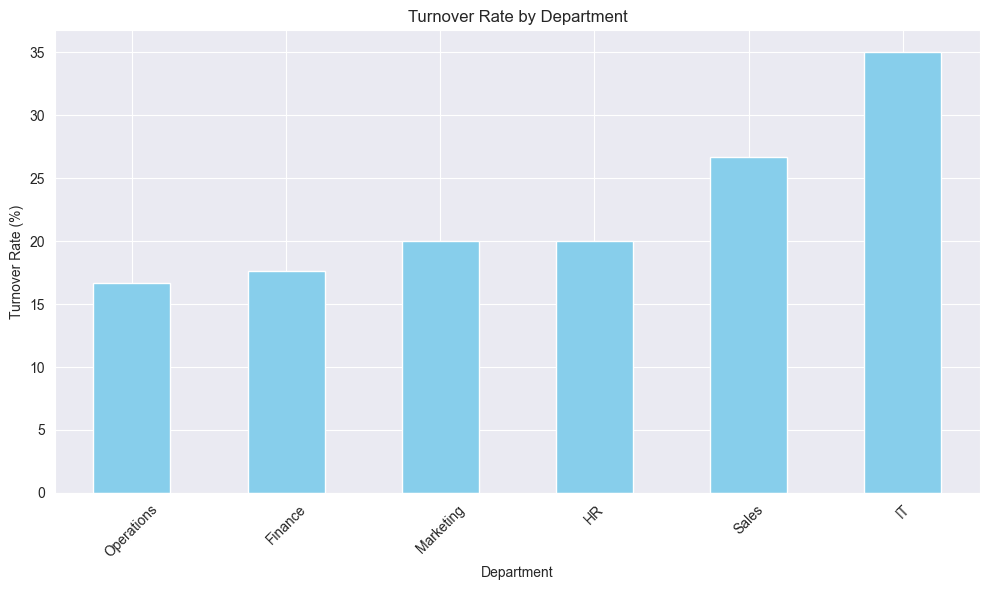

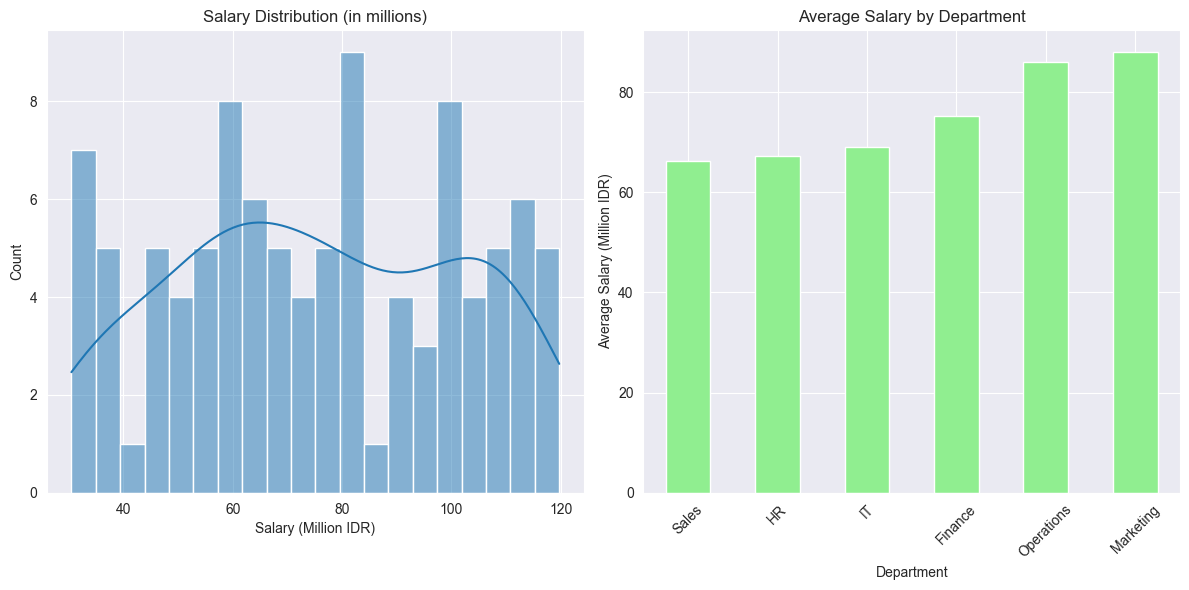

<Figure size 1200x600 with 0 Axes>

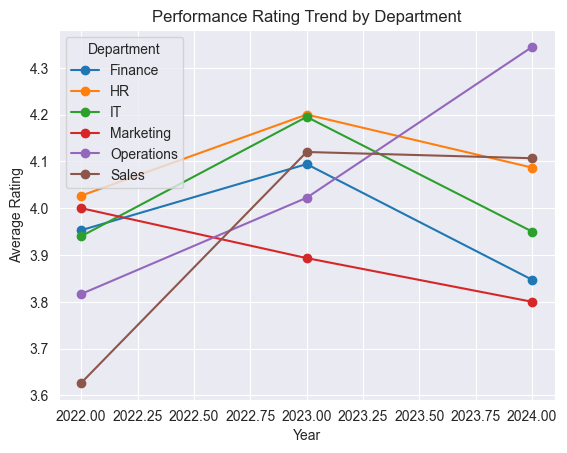

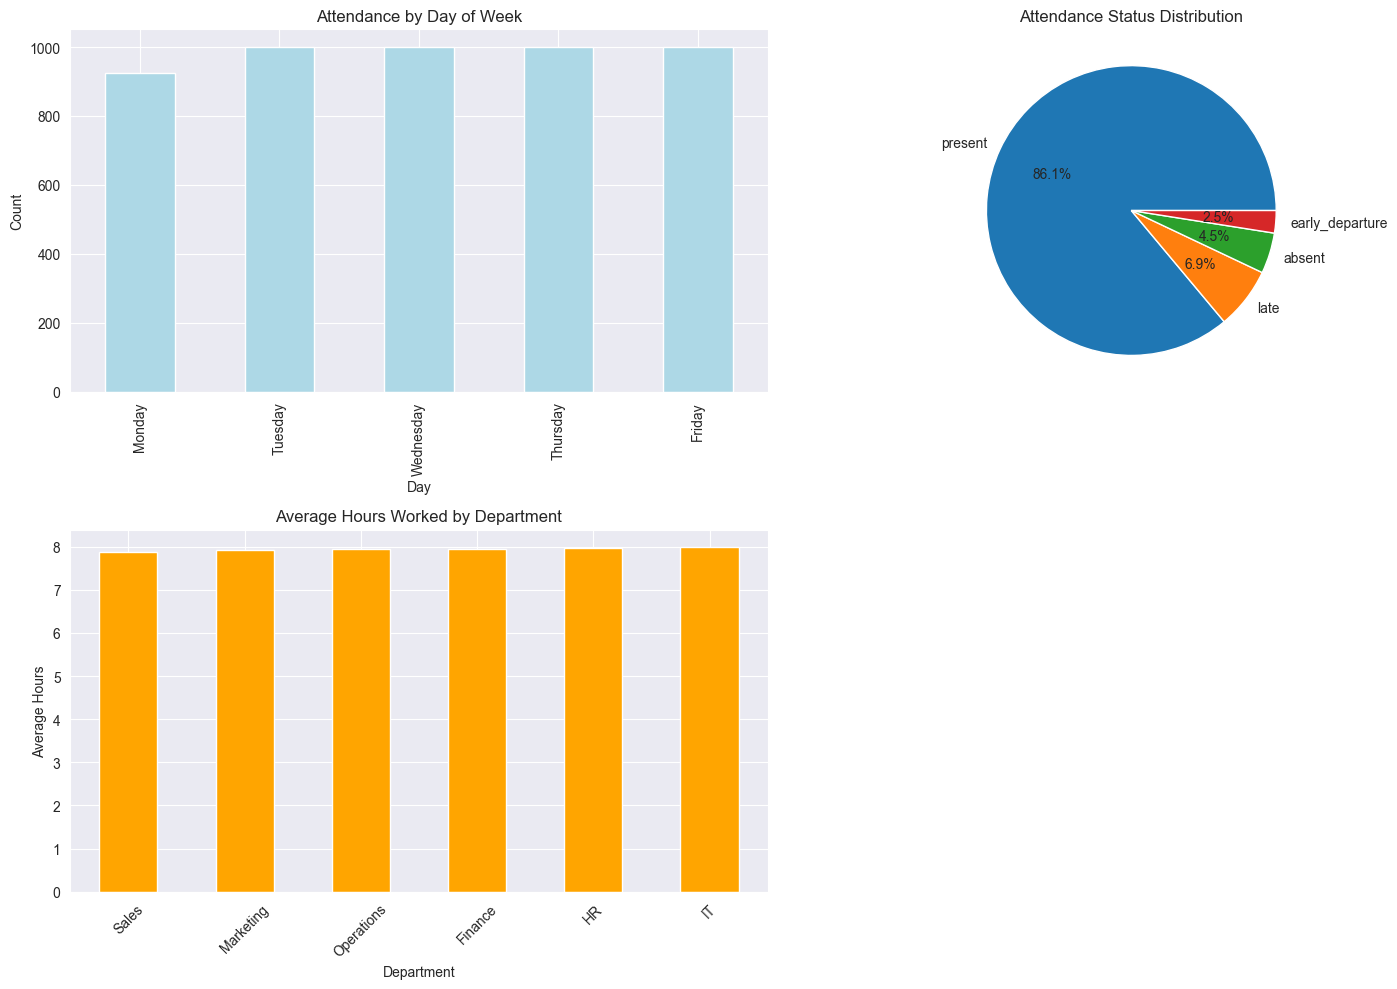


Sample of employees data:
   employee_id   first_name last_name                  email  department  \
0            1  Employee810   Last788  employee1@company.com   Marketing   
1            2  Employee766   Last986  employee2@company.com   Marketing   
2            3  Employee573   Last923  employee3@company.com  Operations   
3            4  Employee108    Last19  employee4@company.com          HR   
4            5  Employee646   Last945  employee5@company.com       Sales   

                 job_title  hire_date     salary  manager_id  status  \
0          Content Creator 2019-07-29   74900229         NaN  active   
1          Content Creator 2020-01-25   97161660         NaN  active   
2  Supply Chain Specialist 2018-05-06  111399487         NaN  active   
3     Training Coordinator 2020-02-11  101540508         NaN  active   
4     Business Development 2019-11-06  113318202         NaN  active   

   tenure_years  salary_million  
0          6.08       74.900229  
1          5.58

In [26]:
# Initialize the model
hr_model = HRAnalyticsModel()

# Generate comprehensive report
report = hr_model.generate_comprehensive_report()

print("=== HR ANALYTICS REPORT ===")
print(f"Total Employees: {report['employee_summary']['total_employees']}")
print(f"Active Employees: {report['employee_summary']['active_employees']}")
print(f"Turnover Rate: {report['turnover_rate']}%")
print(f"\nAverage Salary: {report['employee_summary']['average_salary']}")
print(f"Average Tenure: {report['employee_summary']['average_tenure']}")

print("\n=== DEPARTMENT PERFORMANCE ===")
print(report['department_performance'])

print("\n=== ATTENDANCE STATS ===")
for key, value in report['attendance_stats'].items():
    print(f"{key}: {value}")

# Generate visualizations
hr_model.plot_turnover_by_department()
hr_model.plot_salary_distribution()
hr_model.plot_performance_trends()
hr_model.plot_attendance_patterns()

# Access raw dataframes if needed
print("\nSample of employees data:")
print(hr_model.employees_df.head())
print(f"\nShape of attendance data: {hr_model.attendance_df.shape}")